In [1]:
# Initial imports
import os
import pandas as pd
import requests
import datetime
from datetime import datetime, timedelta, date
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt

#Twitter API imports
import tweepy as tw

# NLP & Sentiment imports
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Setting twitter access and api keys
bearer_token = os.getenv("TWITTER_BEARER_TOKEN")
consumer_key= os.getenv("TWITTER_API_KEY")
consumer_secret= os.getenv("TWITTER_SECRET_KEY")
access_token= os.getenv("TWITTER_ACCESS_TOKEN")
access_token_secret= os.getenv("TWITTER_ACCESS_TOKEN_SECRET")

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [130]:
# authentication for twitter
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
twitter_api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# test authentication
try:
    twitter_api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [136]:
# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Kris/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [137]:
############################################################
"""
    Cleans the tweets and removes the included url
"""
############################################################

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())



############################################################
"""
    Sentiment calculation based on compound score
"""
############################################################

def get_normalized(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

############################################################
"""
    Function that pulls stock data from a given ticker and timeframe.
"""
############################################################

def daily_returns(ticker, timeframe):
        
    # Set current date and the date from one month ago using the ISO format
    current_date = pd.Timestamp.now(tz="America/New_York").isoformat()
    past_date = pd.Timestamp("2020-12-01", tz="America/New_York").isoformat()

    # Get 4 weeks worth of historical data for AAPL
    df = alpaca_api.get_barset(
        ticker,
        timeframe,
        limit=None,
        start=past_date,
        end=current_date,
        after=None,
        until=None,
    ).df
        
    return df



############################################################
"""
    Twitter: Scrape Tweets and Analyze Sentiment
"""
############################################################

def twitter_sentiment(search_words, date_since, items):
    
    # initializing the tweets dataframe
    df = []
    
    # adding retweet filter to search words
    search_words = search_words + " -filter:retweets"
    
    # Fetch top tweets/hastags for given ticker
    tweets = tw.Cursor(twitter_api.search,
              q=search_words,
              lang="en",
              since=date_since
                    ).items(items)
    
    for tweet in tweets:
    
        #Clean text of tweets
        tweet_clean = remove_url(tweet.text)

        # Get date of tweet
        tweet_date = pd.Timestamp(tweet.created_at)
    
        try:
            sentiment = analyzer.polarity_scores(tweet_clean)
            compound = sentiment["compound"]
            pos = sentiment["pos"]
            neu = sentiment["neu"]
            neg = sentiment["neg"]
            # normalized = get_sentiment(compound)
        
            df.append({
                "date": tweet_date,
                "tweet": tweet_clean,
                "compound": compound,
                "positive": pos,
                "negative": neg,
                "neutral": neu
                # "normalized": normalized
            
            })
        
        except AttributeError:
            pass
    
    df = pd.DataFrame(df).set_index(["date"])
    
    return df


In [148]:
# tweepy variables
search_words = "msft"
date_since = "2020-12-01"
items = 10000

# call the twitter sentiment function and return a dataframe
twitter_df = twitter_sentiment(search_words, date_since, items)
twitter_df.index = twitter_df.index.date
twitter_df

Rate limit reached. Sleeping for: 808
Rate limit reached. Sleeping for: 854


,tweet,compound,positive,negative,neutral
2021-01-13,Bast roomGet 20 DAYS FREE TRIALOZSC TLSS VYST ...,0.8429,0.335,0.000,0.665
2021-01-13,Most active trading group Alerts Analysis Stoc...,0.7921,0.413,0.000,0.587
2021-01-13,Discord group20 days free trial Link bioNIO AA...,0.1531,0.143,0.117,0.739
2021-01-13,AlertsUpdate Watchlist Discord group LINK IN B...,-0.4019,0.000,0.162,0.838
2021-01-13,matvelloso I interviewed on a miserably cold d...,0.8069,0.341,0.102,0.558
...,...,...,...,...,...
2021-01-05,FCC ID filing for WiFi 6 AX201 1961 by Microso...,0.0000,0.000,0.000,1.000
2021-01-05,HiddenCash I will personally wait until Thursd...,0.0000,0.000,0.000,1.000
2021-01-05,FCC ID filing for LTEA Cat 12 M2 Module 1988 b...,0.0000,0.000,0.000,1.000
2021-01-05,RKT 17 M buy at end of day AAPL SPY MSFT PLTR XLE,0.0000,0.000,0.000,1.000


In [155]:
# Get descriptive stats from the DataFrame
twitter_df.describe()

,compound,positive,negative,neutral
count,6989.000000,6989.000000,6989.000000,6989.000000
mean,0.162926,0.104449,0.031333,0.864217
std,0.342555,0.135578,0.077619,0.151307
min,-0.923100,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.766000
50%,0.000000,0.000000,0.000000,0.891000
75%,0.421500,0.182000,0.000000,1.000000
max,0.960300,0.833000,1.000000,1.000000


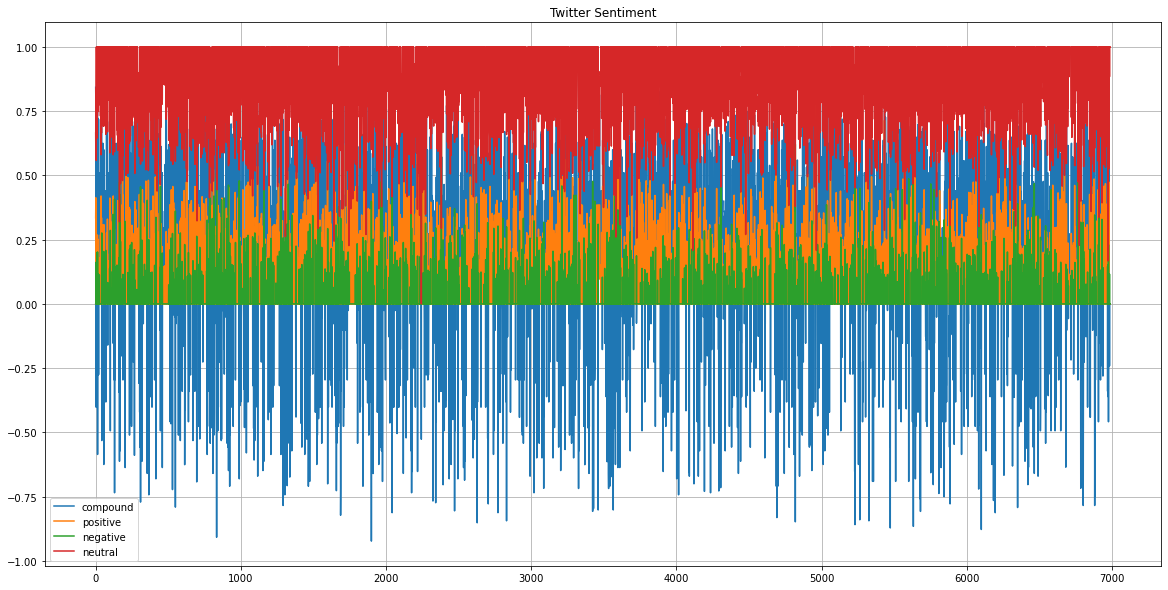

In [156]:
twitter_df.plot(
    y=["compound", "positive", "negative", "neutral"],
    kind="line",
    title= "Twitter Sentiment",
    figsize= (20,10),
    grid=True,
);


In [157]:
# Grouping the tweets by day and taking their avererage daily sentiment
twitter_df.reset_index(inplace = True)
twitter_df.rename(columns = {'index':'date'}, inplace = True)
avg_daily_sentiment = twitter_df.groupby("date").mean()
avg_daily_sentiment


ValueError: Grouper for 'date' not 1-dimensional

In [158]:
avg_daily_sentiment["normalized"] = avg_daily_sentiment["compound"].apply(lambda x : get_normalized(x))
avg_daily_sentiment

,compound,positive,negative,neutral,normalized
date,,,,,
2021-01-05,0.095618,0.058727,0.010545,0.930727,1
2021-01-06,0.150791,0.098759,0.033191,0.868040,1
2021-01-07,0.188939,0.111287,0.028765,0.859937,1
2021-01-08,0.188895,0.106245,0.022480,0.871276,1
2021-01-09,0.128814,0.102814,0.034828,0.862354,1
2021-01-10,0.116497,0.083195,0.030292,0.886533,1
2021-01-11,0.168310,0.113333,0.035867,0.850803,1
2021-01-12,0.171495,0.109529,0.033517,0.856950,1
2021-01-13,0.181937,0.104660,0.032110,0.863245,1


In [159]:
# alpaca api variables
ticker = "MSFT"
timeframe = "1D"

# call the alpaca api and return a dataframe of daily returns
daily_df = daily_returns(ticker, timeframe)


# Drop Outer Table Level and drop extra columns
daily_df = daily_df.droplevel(axis=1, level=0)
daily_df = daily_df.drop(columns=["open", "high", "low", "volume"])

# remove the time component of the data
daily_df.index = daily_df.index.date


returns_df = daily_df.pct_change().dropna()
returns_df

,close
2020-12-02,-0.003654
2020-12-03,-0.005338
2020-12-04,0.000607
2020-12-07,-0.000373
2020-12-08,0.007792
2020-12-09,-0.021205
2020-12-10,-0.004233
2020-12-11,0.013087
2020-12-14,0.004314
2020-12-15,-0.000140


In [160]:
combined_df = returns_df.join(avg_daily_sentiment).dropna(how="any")

display(combined_df)

,close,compound,positive,negative,neutral,normalized
2021-01-05,0.000918,0.095618,0.058727,0.010545,0.930727,1.0
2021-01-06,-0.026558,0.150791,0.098759,0.033191,0.868040,1.0
2021-01-07,0.028602,0.188939,0.111287,0.028765,0.859937,1.0
2021-01-08,0.005772,0.188895,0.106245,0.022480,0.871276,1.0
2021-01-11,-0.009337,0.168310,0.113333,0.035867,0.850803,1.0
2021-01-12,-0.011816,0.171495,0.109529,0.033517,0.856950,1.0


In [161]:
# Correlate the twitter sentiment to returns
combined_df.corr().style.background_gradient()

/opt/anaconda3/envs/nlpenv/lib/python3.7/site-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/anaconda3/envs/nlpenv/lib/python3.7/site-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,close,compound,positive,negative,neutral,normalized
close,1.000000,0.297640,0.057992,-0.347457,0.071992,nan
compound,0.297640,1.000000,0.940470,0.643692,-0.874189,nan
positive,0.057992,0.940470,1.000000,0.857864,-0.985925,nan
negative,-0.347457,0.643692,0.857864,1.000000,-0.931703,nan
neutral,0.071992,-0.874189,-0.985925,-0.931703,1.000000,nan
normalized,nan,nan,nan,nan,nan,nan
